In [1]:
from langchain.prompts import PromptTemplate
from langchain.chains.llm import LLMChain
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
from langchain.text_splitter import CharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings


In [2]:
llm = ChatGoogleGenerativeAI(
        model="gemini-1.5-pro",
        temperature=0.5,  # Adjusted temperature for variety
        max_tokens=150,   # Set max tokens to avoid None issues
        timeout=None,
        max_retries=2,
    )

In [3]:
llm.invoke("hi").content

'Hi there! How can I help you today?\n'

In [5]:
!pip install -U langgraph

  Using cached langgraph-0.2.60-py3-none-any.whl.metadata (15 kB)
  Using cached langgraph_checkpoint-2.0.9-py3-none-any.whl.metadata (4.6 kB)
  Using cached langgraph_sdk-0.1.48-py3-none-any.whl.metadata (1.8 kB)
  Using cached msgpack-1.1.0-cp311-cp311-win_amd64.whl.metadata (8.6 kB)
Using cached langgraph-0.2.60-py3-none-any.whl (135 kB)
Using cached langgraph_checkpoint-2.0.9-py3-none-any.whl (37 kB)
Using cached langgraph_sdk-0.1.48-py3-none-any.whl (43 kB)
Using cached msgpack-1.1.0-cp311-cp311-win_amd64.whl (74 kB)


In [7]:
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.graph.message import add_messages
from typing import Annotated , Literal , TypedDict
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

In [8]:
def call_model(state:MessagesState):
    messages = state['messages']
    response = llm.invoke(messages)
    return{"messages":[response]}

In [9]:
workflow = StateGraph(MessagesState)  # Step 1: Create a workflow deals with message input
workflow.add_node("chatbot", call_model)  # Step 2: Add a node for the chatbot
workflow.add_edge(START, "chatbot")  # Step 3: Connect the START to the chatbot node
workflow.add_edge("chatbot", END)  # Step 4: Connect the chatbot node to the END
app = workflow.compile()  # Step 5: Compile the workflow to make it executable


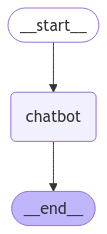

In [13]:
from IPython.display import Image, display
import io

# Get the PNG image data from draw_mermaid_png
graph = app.get_graph()
png_data = graph.draw_mermaid_png()

# Display the image directly from the data
display(Image(data=png_data))


In [ ]:
#messagestate which has content which pass through different nodes

In [15]:
input = {"messages": ["hi, my name is ananth"]}
app.invoke(input)


{'messages': [HumanMessage(content='hi, my name is ananth', additional_kwargs={}, response_metadata={}, id='8903f036-d00b-4513-8f09-de5cc5172372'),
  AIMessage(content="Hi Ananth, it's nice to meet you!\n", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-80a1b1d9-25b7-4d85-a454-72b7ea0060db-0', usage_metadata={'input_tokens': 8, 'output_tokens': 13, 'total_tokens': 21, 'input_token_details': {'cache_read': 0}})]}

LLM WITH TOOLS

In [17]:
@tool
def searchh(query: str):
    """
    Search for weather information based on the query.
    If the query mentions 'sf' or 'San Francisco', it returns the weather for San Francisco.
    Otherwise, it returns a default hot weather response.
    """
    if "sf" in query.lower() or "san francisco" in query.lower():
        return "it's 60 degrees and foggy"
    return "it is 90 degrees and hot"


In [18]:
searchh.invoke("what is temperature in sf")

"it's 60 degrees and foggy"

In [19]:
searchh.invoke("what is temperature in india")

'it is 90 degrees and hot'

In [20]:
tools = [searchh]

In [21]:
tool_nodes = ToolNode(tools) #creating search as node

In [22]:
#binding llm and tool
llm_with_tools = llm.bind_tools(tools)

In [23]:
def call_model(state:MessagesState):
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return{"messages":[response]}

In [24]:
response = call_model({"messages": ["hi, my name is ananth"]})

In [25]:
response

{'messages': [AIMessage(content='Hi Ananth, nice to meet you!\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-fa2e809f-5560-4915-a3af-206d683e1b02-0', usage_metadata={'input_tokens': 80, 'output_tokens': 10, 'total_tokens': 90, 'input_token_details': {'cache_read': 0}})]}

In [26]:
messages = response['messages']

In [27]:
last_message = messages[-1]

In [29]:
last_message.tool_calls

[]

In [30]:
response = call_model({"messages": ["what is the temperature in sf?"]})

In [31]:
messages = response['messages']

In [32]:
last_message = messages[-1]

In [33]:
last_message.tool_calls #where we can tool is used here

[{'name': 'searchh',
  'args': {'query': 'sf'},
  'id': '04d2cee6-371d-43cf-ad45-d12dbda91d79',
  'type': 'tool_call'}]

In [34]:
def router_function(state:MessagesState) -> Literal["tools",END]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [35]:
#define flow
workflow = StateGraph(MessagesState)
workflow.add_node("agent" , call_model)
workflow.add_node("tools",tool_nodes)
workflow.add_edge(START,"agent")
workflow.add_conditional_edges("agent",router_function,{"tools":"tools",END:END})
app = workflow.compile()


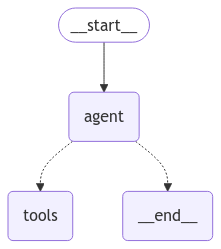

In [37]:
app.invoke({"messages":["hi how are you?"]})

{'messages': [HumanMessage(content='hi how are you?', additional_kwargs={}, response_metadata={}, id='43026911-2e46-404a-b754-b0143d8878b4'),
  AIMessage(content='I am doing well, thank you for asking. How can I help you today?\n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-c48a52a8-7bb5-4b83-bb8b-da3791404d16-0', usage_metadata={'input_tokens': 78, 'output_tokens': 18, 'total_tokens': 96, 'input_token_details': {'cache_read': 0}})]}

In [38]:
app.invoke({"messages":["temperature sa?"]})

{'messages': [HumanMessage(content='temperature sa?', additional_kwargs={}, response_metadata={}, id='2789fcf0-66f2-4961-aa06-8a5cdf0d3fc7'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'searchh', 'arguments': '{"query": "sa"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-f2218ae8-70aa-48b8-b07d-94c4ae2b9714-0', tool_calls=[{'name': 'searchh', 'args': {'query': 'sa'}, 'id': 'ae07e7cf-1697-4513-891a-fd298a867d83', 'type': 'tool_call'}], usage_metadata={'input_tokens': 76, 'output_tokens': 4, 'total_tokens': 80, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='it is 90 degrees and hot', name='searchh', id='4e39861d-53ab-492c-a90e-96f1ab300d36', tool_call_id='ae07e7cf-1697-4513-891a-fd298a867d83')]}

In [ ]:
'''Flow Execution
Starting the Workflow:

The conversation begins at the "agent" node.
The agent node calls the LLM (call_model) to generate a response or take an action.
Routing Decision:

The router_function inspects the latest message:
If tool_calls exists, it routes to the "tools" node for further tool-based processing.
Otherwise, it terminates the conversation (END).
Tools Node:

At the "tools" node, external tools or predefined actions are executed based on the requirements.
End of Flow:

If the flow reaches END, the workflow stops. '''